# **Loan Default Prediction** using *LightGBM + SHAP* 

In [1]:
!pip uninstall -y imbalanced-learn scikit-learn
!pip install -q "scikit-learn==1.5.2" "imbalanced-learn==0.12.3" "category-encoders==2.7.0"
!pip uninstall -y cesium

Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
Found existing installation: cesium 0.12.4
Uninstalling cesium-0.12.4:
  Successfully uninstalled cesium-0.12.4


In [2]:
!pip install -q numerize
!pip install -q category_encoders
!pip install -q torchmetrics
!pip install -q torchsampler
!pip install -q shap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into a

## **Libraries**

In [3]:
# 📦 Core Libraries
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Preprocessing & Feature Engineering
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split

# ⚖️ Data Balancing (Oversampling / Undersampling)
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from torchsampler import ImbalancedDatasetSampler

# 🧠 Machine Learning Models
# Tree-based Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Linear & Probabilistic Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Instance-based Models
from sklearn.neighbors import KNeighborsClassifier

# 🧩 Deep Learning Utilities
import torch
from torch.utils.data import Dataset, DataLoader

# 📈 Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    classification_report,
    confusion_matrix,
)

# 💾 Persistence / Saving
import joblib
import pathlib
from pathlib import Path

# ⚠️ Miscellaneous Settings
warnings.filterwarnings('ignore')

# **Loading Data**

In [4]:
DATA_PATH = Path("../input/loan-default/Loan_default.csv")   # <-- update if file is elsewhere
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

In [5]:
print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
df = df.sample(50000)

print(f"Loaded dataset with {df.shape[0]:,} rows and {df.shape[1]:,} columns.\n")

Loading dataset...
Loaded dataset with 50,000 rows and 18 columns.



In [6]:
print("First few rows:")
display(df.head(5))

First few rows:


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
84537,R8TCJHBHVE,54,127532,241363,397,32,4,4.40,12,0.40,Master's,Unemployed,Married,Yes,Yes,Auto,No,0
179211,JSFA410H8V,44,120907,27337,345,76,3,14.86,36,0.72,High School,Part-time,Married,Yes,Yes,Education,No,0
79217,2DJL9AEHHM,66,30203,9984,369,41,2,4.49,24,0.23,High School,Part-time,Married,No,Yes,Auto,No,0
169066,0KFM6E5RVD,34,75142,28134,659,73,1,21.68,36,0.54,Bachelor's,Full-time,Married,No,Yes,Education,Yes,0
37134,CNPD118Y5T,35,147129,207096,434,66,2,22.87,12,0.65,High School,Unemployed,Married,Yes,No,Other,No,0


In [7]:
print("\nColumn information:")
print(df.info())


Column information:
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 84537 to 47481
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LoanID          50000 non-null  object 
 1   Age             50000 non-null  int64  
 2   Income          50000 non-null  int64  
 3   LoanAmount      50000 non-null  int64  
 4   CreditScore     50000 non-null  int64  
 5   MonthsEmployed  50000 non-null  int64  
 6   NumCreditLines  50000 non-null  int64  
 7   InterestRate    50000 non-null  float64
 8   LoanTerm        50000 non-null  int64  
 9   DTIRatio        50000 non-null  float64
 10  Education       50000 non-null  object 
 11  EmploymentType  50000 non-null  object 
 12  MaritalStatus   50000 non-null  object 
 13  HasMortgage     50000 non-null  object 
 14  HasDependents   50000 non-null  object 
 15  LoanPurpose     50000 non-null  object 
 16  HasCoSigner     50000 non-null  object 
 17  Default    

In [8]:
print("\nSummary statistics:")
display(df.describe(include='all').T)


Summary statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
LoanID,50000,50000,R8TCJHBHVE,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,"50,000.00",NaN,NaN,NaN,43.61,15.05,18.00,30.00,44.00,57.00,69.00
Income,"50,000.00",NaN,NaN,NaN,"82,639.75","39,010.45","15,002.00","48,992.75","82,480.50","116,519.00","149,997.00"
LoanAmount,"50,000.00",NaN,NaN,NaN,"127,532.03","70,928.69","5,016.00","65,944.50","127,405.00","188,844.25","249,992.00"
CreditScore,"50,000.00",NaN,NaN,NaN,574.30,158.43,300.00,438.00,575.00,711.00,849.00
MonthsEmployed,"50,000.00",NaN,NaN,NaN,59.39,34.57,0.00,30.00,59.00,89.00,119.00
NumCreditLines,"50,000.00",NaN,NaN,NaN,2.50,1.12,1.00,1.00,2.00,4.00,4.00
InterestRate,"50,000.00",NaN,NaN,NaN,13.48,6.64,2.00,7.74,13.45,19.23,25.00
LoanTerm,"50,000.00",NaN,NaN,NaN,36.06,16.95,12.00,24.00,36.00,48.00,60.00
DTIRatio,"50,000.00",NaN,NaN,NaN,0.50,0.23,0.10,0.30,0.50,0.70,0.90


In [9]:
print("\n🚨 Missing Values Report:")
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
if len(missing) == 0:
    print("✅ No missing values detected.")
else:
    print(missing)


🚨 Missing Values Report:
✅ No missing values detected.


In [10]:
print("\n🧾 Data Type Counts:")
print(df.dtypes.value_counts())


🧾 Data Type Counts:
object     8
int64      8
float64    2
Name: count, dtype: int64


In [11]:
if "Default" in df.columns:
    print("\n⚖️ Default Class Distribution:")
    class_counts = df["Default"].value_counts(dropna=False)
    class_ratio = df["Default"].value_counts(normalize=True)
    summary = pd.concat([class_counts, class_ratio], axis=1)
    summary.columns = ["Count", "Proportion"]
    display(summary)
else:
    print("⚠️ Target column 'Default' not found in dataset.")


⚖️ Default Class Distribution:


,Count,Proportion
Default,,
0,44123,0.88
1,5877,0.12


In [12]:
num_cols = df.select_dtypes(include=["int", "float"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["int", "float"]).columns.tolist()

print(f"\nNumeric features: {len(num_cols)} → {num_cols}")
print(f"Categorical features: {len(cat_cols)} → {cat_cols}")


Numeric features: 10 → ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Default']
Categorical features: 8 → ['LoanID', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']



📊 Correlation with Target (numeric only):


InterestRate      0.14
LoanAmount        0.08
NumCreditLines    0.03
DTIRatio          0.03
LoanTerm          0.00
CreditScore      -0.04
Income           -0.09
MonthsEmployed   -0.10
Age              -0.17
dtype: float64

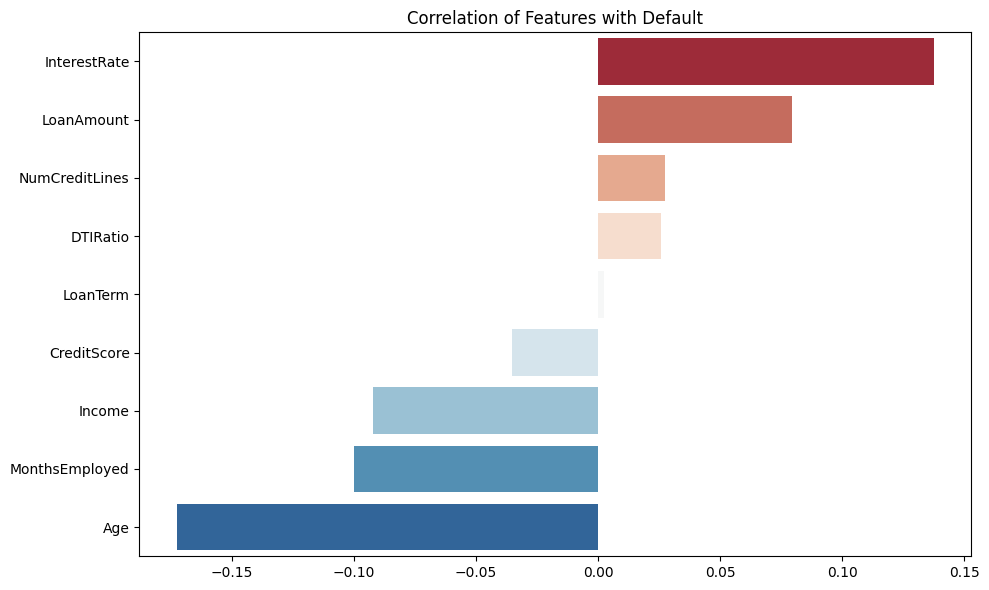

In [13]:
if "Default" in df.columns:
    print("\n📊 Correlation with Target (numeric only):")

    num_cols = df.select_dtypes(include=[np.number]).columns

    num_cols = [col for col in num_cols if col != "Default"]

    corr = df[num_cols].corrwith(df["Default"]).sort_values(ascending=False)

    display(corr)

    plt.figure(figsize=(10,6))
    sns.barplot(x=corr.values, y=corr.index, palette="RdBu")
    plt.title("Correlation of Features with Default")
    plt.tight_layout()
    plt.show()

# **Feature Engineering**

| **Column**                   | **Computation**                                                                     | **Meaning / Purpose**             |
| ---------------------------- | ----------------------------------------------------------------------------------- | --------------------------------- |
| LoanToIncomeRatio            | LoanAmount ÷ Income                                                                 | Borrowing load relative to income |
| DebtBurdenIndex              | DTIRatio × LoanToIncomeRatio                                                        | Combined debt pressure indicator  |
| EffectiveInterestExposure    | (InterestRate × LoanTerm)/12                                                        | Total interest exposure over term |
| RiskAdjustedLoan             | LoanAmount × (1 / CreditScore)                                                      | Loan scaled by credit quality     |
| CreditUtilizationRatio       | LoanAmount ÷ (NumCreditLines × Income / 12 + 1e-6)                                  | Credit usage intensity            |
| EmploymentStabilityScore     | log1p(MonthsEmployed)                                                               | Tenure stability measure          |
| CreditLinesPerYear           | NumCreditLines ÷ (MonthsEmployed/12 + 1)                                            | Credit activity per working year  |
| CareerContinuityIndex        | (MonthsEmployed ÷ (LoanTerm + 1)) × 10                                              | Career length vs. loan horizon    |
| IncomeStabilityIndex         | (1 / (1 + DTIRatio)) × log1p(MonthsEmployed)                                        | Earnings reliability proxy        |
| FinancialHealthIndex         | Weighted mix of CreditScore, LoanToIncomeRatio, DTIRatio                            | Overall financial strength        |
| BorrowingPressureScore       | Weighted mix of InterestRate, LoanTerm, DTIRatio                                    | Borrowing strain indicator        |
| CreditMaturityIndex          | (LoanTerm/12) ÷ (NumCreditLines + 1)                                                | Credit maturity breadth           |
| IncomeCreditScoreInteraction | Income × CreditScore                                                                | Non-linear income–credit link     |
| LoanTermByInterest           | LoanTerm × InterestRate                                                             | Interest load over duration       |
| CombinedDebtIndex            | DTIRatio × LoanToIncomeRatio                                                        | Compound debt stress metric       |
| EducationLevelIndex          | Map education to 1–4                                                                | Education ordinal signal          |
| EmploymentStabilityWeight    | Map employment type to weight                                                       | Job-type reliability factor       |
| DigitalFootprintScore        | From education, employment, income + noise                                          | Online presence consistency       |
| ProfileVerificationCount     | Poisson(age, mortgage)                                                              | Verified-profile count            |
| IdentityStabilityYears       | Uniform(Age×0.3 – Age×0.8)                                                          | Age of digital identity           |
| MultiPlatformPresence        | Bernoulli(education, income)                                                        | Presence across platforms         |
| OnlinePurchaseReliability    | Normal(income, DTIRatio)                                                            | Digital transaction reliability   |
| UtilityPaymentConsistency    | Normal(months employed, employment)                                                 | On-time utility payments          |
| EcommerceSpendingRatio       | Normal(age)                                                                         | Share of income spent online      |
| DigitalSubscriptionCount     | Poisson(education, income)                                                          | Number of active subscriptions    |
| SocialTrustScore             | Normal(education, employment)                                                       | Public trust proxy                |
| PublicComplaintCount         | Poisson(2 – 2 × SocialTrustScore)                                                   | Public dispute frequency          |
| EndorsementCount             | Poisson(education, employment)                                                      | Professional/social endorsements  |
| ReviewSentimentIndex         | SocialTrustScore + noise                                                            | Public sentiment polarity         |
| ResponseLatencyAvgHrs        | 24 – 12 × DigitalFootprintScore – 6 × FullTime                                      | Typical response latency          |
| VerificationResponseRate     | Normal(education, employment)                                                       | Response rate to verifications    |
| ActiveDeviceCount            | Poisson(income)                                                                     | Registered device count           |
| DigitalFinanceLiteracyScore  | Normal(education, age)                                                              | Digital finance proficiency       |
| MobileBankingUsageLevel      | Normal(income, age)                                                                 | Mobile banking engagement         |
| FinancialAppCount            | Poisson(income, age)                                                                | Fintech app usage count           |
| PublicRecordDiscrepancyCount | Poisson(2 – 1.5 × DigitalFootprintScore)                                            | Registry mismatches               |
| LegalInquiryCount            | Poisson(3 – 2 × SocialTrustScore)                                                   | Minor legal inquiries             |
| AddressVerificationLevel     | DigitalFootprintScore + noise                                                       | Address consistency score         |
| CivicEngagementIndex         | Normal(education, age, income)                                                      | Civic/social participation        |
| VoterRegistrationStatus      | Bernoulli(age)                                                                      | Registered voter flag             |
| CommunityAffiliationCount    | Poisson(marital status)                                                             | Community memberships             |
| ProfessionalEndorsementScore | Normal(employment type)                                                             | Professional reputation           |
| JobChangeFrequency5Y         | 3 – log1p(MonthsEmployed)/2 + noise                                                 | Job turnover frequency            |
| PublicWorkPortfolioScore     | Normal(self-employment, education)                                                  | Online professional visibility    |
| DigitalTrustComposite        | Mean(DigitalFootprintScore, SocialTrustScore, AddressVerificationLevel)             | Aggregate digital trust           |
| CivicResponsibilityIndex     | Mean(CivicEngagementIndex, VoterRegistrationStatus)                                 | Civic responsibility level        |
| OnlineBehaviorIndex          | Mean(OnlinePurchaseReliability, UtilityPaymentConsistency, MobileBankingUsageLevel) | Aggregate online discipline       |

In [14]:
class LoanFeatureEngineer:
    def __init__(self):
        self.edu_map = {"High School": 1, "Bachelor's": 2, "Master's": 3, "PhD": 4}
        self.medians = None
        self.columns = None

    def fit(self, df):
        DF = self._engineer_features(df.copy())
        self.medians = DF.median(numeric_only=True)
        self.columns = DF.columns.tolist()
        return DF

    def transform(self, df):
        DF = self._engineer_features(df.copy())
        DF = DF.fillna(self.medians)
        if self.columns is not None:
            DF = DF.reindex(columns=self.columns, fill_value=0)
        return DF

    def save(self, path):
        joblib.dump({'medians': self.medians, 'columns': self.columns}, path)

    def load(self, path):
        state = joblib.load(path)
        self.medians = state['medians']
        self.columns = state['columns']

    def _engineer_features(self, df):
        rng = np.random.default_rng(42)
        # ========== NUMERIC DERIVATIVES ==========
        df["LoanToIncomeRatio"] = (df["LoanAmount"] / df["Income"]).replace([np.inf, -np.inf], np.nan)
        df["DebtBurdenIndex"] = df["DTIRatio"] * df["LoanToIncomeRatio"]
        df["EffectiveInterestExposure"] = (df["InterestRate"] * df["LoanTerm"]) / 12
        df["RiskAdjustedLoan"] = df["LoanAmount"] * (1 / df["CreditScore"].replace(0, np.nan))
        df["CreditUtilizationRatio"] = df["LoanAmount"] / (df["NumCreditLines"] * df["Income"] / 12 + 1e-6)
        df["EmploymentStabilityScore"] = np.log1p(df["MonthsEmployed"])
        df["CreditLinesPerYear"] = df["NumCreditLines"] / ((df["MonthsEmployed"] / 12) + 1)
        df["CareerContinuityIndex"] = (df["MonthsEmployed"] / (df["LoanTerm"] + 1)) * 10
        df["IncomeStabilityIndex"] = (1 / (1 + df["DTIRatio"])) * np.log1p(df["MonthsEmployed"])
        df["FinancialHealthIndex"] = (
            (df["CreditScore"] / 850) * 0.5 +
            (1 - df["LoanToIncomeRatio"].clip(0, 2)) * 0.3 +
            (1 - df["DTIRatio"].clip(0, 1.5)) * 0.2
        )
        df["BorrowingPressureScore"] = (
            (df["InterestRate"] / 100) * 0.4 +
            (df["LoanTerm"] / 60) * 0.3 +
            (df["DTIRatio"].clip(0, 2)) * 0.3
        )
        df["CreditMaturityIndex"] = (df["LoanTerm"] / 12) / (df["NumCreditLines"] + 1)
        df["IncomeCreditScoreInteraction"] = df["Income"] * df["CreditScore"]
        df["LoanTermByInterest"] = df["LoanTerm"] * df["InterestRate"]
        df["CombinedDebtIndex"] = df["DTIRatio"] * df["LoanToIncomeRatio"]

        # ========== CATEGORICAL/ORDINAL SIGNALS ==========
        if "Education" in df.columns and df["Education"].dtype == object:
            df["EducationLevelIndex"] = df["Education"].map(self.edu_map).fillna(0).astype(int)
        else:
            df["EducationLevelIndex"] = 0

        def _flag(col, value):
            return (df[col] == value).astype(float) if (col in df.columns and df[col].dtype == object) else 0.0
        is_full_time = _flag("EmploymentType", "Full-time")
        is_self_emp  = _flag("EmploymentType", "Self-employed")
        is_unemp     = _flag("EmploymentType", "Unemployed")
        is_part_time = _flag("EmploymentType", "Part-time")
        is_married   = _flag("MaritalStatus", "Married")
        df["EmploymentStabilityWeight"] = (
            1.0 * is_full_time +
            0.7 * is_part_time +
            0.6 * is_self_emp +
            0.0 * is_unemp
        ).replace(0, np.nan).fillna(0.5)

        # ========== SYNTHETIC / SEMANTIC FEATURES ==========
        # Digital identity & verification
        base_dfp = 0.65 + 0.1 * df["EducationLevelIndex"] / 4 + 0.08 * is_full_time + 0.05 * np.log1p(df["Income"]) / np.log(1e6)
        df["DigitalFootprintScore"] = np.clip(base_dfp + rng.normal(0, 0.08, len(df)), 0, 1)
        # --- Digital identity & verification ---
        # Ensure HasMortgage is numeric 0/1 for this computation:
        if "HasMortgage" in df.columns:
            # Map Yes/No or 1/0 to 1/0 (as int)
            if df["HasMortgage"].dtype == object:
                has_mort = df["HasMortgage"].map({"Yes":1,"No":0}).fillna(0)
            else:
                has_mort = df["HasMortgage"].fillna(0).astype(float)
        else:
            has_mort = 0.0
        
        lam_pvc = 1.5 + 0.05 * (df["Age"] / 10) + 0.4 * has_mort
        # Clip lambda to reasonable range for poisson (avoid too-large/too-small):
        lam_pvc = np.clip(lam_pvc, 0.1, 5)
        df["ProfileVerificationCount"] = np.clip(rng.poisson(lam=lam_pvc), 0, 5).astype(int)

        low = (df["Age"] * 0.3).clip(lower=0)
        high = (df["Age"] * 0.8).clip(lower=0)
        df["IdentityStabilityYears"] = np.clip(rng.uniform(low, high), 0, None).round(1)
        p_multi = np.clip(0.3 + 0.2 * (df["EducationLevelIndex"]/4) + 0.1 * np.log1p(df["Income"])/np.log(1e6), 0, 0.95)
        df["MultiPlatformPresence"] = rng.binomial(1, p_multi).astype(int)
        # Transactional behavior
        mu_opr = 0.7 + 0.1 * (df["Income"] / 100_000) - 0.1 * df["DTIRatio"]
        df["OnlinePurchaseReliability"] = np.clip(mu_opr + rng.normal(0, 0.12, len(df)), 0, 1)
        mu_upc = 0.6 + 0.2 * (np.log1p(df["MonthsEmployed"])/5) + 0.05 * is_full_time
        df["UtilityPaymentConsistency"] = np.clip(mu_upc + rng.normal(0, 0.08, len(df)), 0, 1)
        mu_esr = 0.15 + 0.0005 * (35 - df["Age"])
        df["EcommerceSpendingRatio"] = np.clip(mu_esr + rng.normal(0, 0.04, len(df)), 0, 0.4)
        lam_dsc = 1.5 + 0.5 * (df["EducationLevelIndex"]) + 0.001 * (df["Income"] / 1000)
        df["DigitalSubscriptionCount"] = np.clip(rng.poisson(lam=np.clip(lam_dsc, 0.1, 10)), 0, 10).astype(int)
        # Social trust & sentiment
        mu_sts = 0.5 + 0.05 * (df["EducationLevelIndex"]) + 0.05 * is_full_time
        df["SocialTrustScore"] = np.clip(mu_sts + rng.normal(0, 0.12, len(df)), 0, 1)
        lam_pcc = 2 - 2 * df["SocialTrustScore"]
        df["PublicComplaintCount"] = np.clip(rng.poisson(lam=np.clip(lam_pcc, 0.05, 5)), 0, 5).astype(int)
        lam_end = 1 + 0.5 * is_full_time + 0.5 * (df["EducationLevelIndex"])
        df["EndorsementCount"] = np.clip(rng.poisson(lam=np.clip(lam_end, 0.05, 10)), 0, 10).astype(int)
        df["ReviewSentimentIndex"] = np.clip(df["SocialTrustScore"] + rng.normal(0, 0.1, len(df)), 0, 1)
        # Communication & responsiveness
        mu_lat = 24 - 12 * df["DigitalFootprintScore"] - 6 * is_full_time
        df["ResponseLatencyAvgHrs"] = np.clip(mu_lat + rng.normal(0, 4, len(df)), 1, 48).round(1)
        mu_vrr = 0.75 + 0.1 * is_full_time + 0.05 * (df["EducationLevelIndex"]/4)
        df["VerificationResponseRate"] = np.clip(mu_vrr + rng.normal(0, 0.08, len(df)), 0, 1)
        lam_adc = 1 + 0.002 * (df["Income"] / 1000)
        df["ActiveDeviceCount"] = np.clip(rng.poisson(lam=np.clip(lam_adc, 0.1, 6)), 1, 6).astype(int)
        # Digital financial literacy
        mu_dfl = 0.5 + 0.1 * (df["EducationLevelIndex"]) - 0.003 * df["Age"]
        df["DigitalFinanceLiteracyScore"] = np.clip(mu_dfl + rng.normal(0, 0.08, len(df)), 0, 1)
        mu_mbu = 0.5 - 0.004 * df["Age"] + 0.1 * (np.log1p(df["Income"]) / np.log(1e6))
        df["MobileBankingUsageLevel"] = np.clip(mu_mbu + rng.normal(0, 0.08, len(df)), 0, 1)
        lam_fac = 2 + 0.002 * (df["Income"] / 1000) - 0.03 * (df["Age"] - 30)
        df["FinancialAppCount"] = np.clip(rng.poisson(lam=np.clip(lam_fac, 0.1, 10)), 0, 10).astype(int)
        # Public records & legal standing
        lam_prd = 2 - 1.5 * df["DigitalFootprintScore"]
        df["PublicRecordDiscrepancyCount"] = np.clip(rng.poisson(lam=np.clip(lam_prd, 0.05, 4)), 0, 4).astype(int)
        lam_lic = 3 - 2 * df["SocialTrustScore"]
        df["LegalInquiryCount"] = np.clip(rng.poisson(lam=np.clip(lam_lic, 0.05, 5)), 0, 5).astype(int)
        df["AddressVerificationLevel"] = np.clip(df["DigitalFootprintScore"] + rng.normal(0, 0.08, len(df)), 0, 1)
        # Civic engagement
        mu_cei = 0.3 + 0.1 * (df["EducationLevelIndex"]) + 0.0005 * (df["Age"] + df["Income"] / 10_000)
        df["CivicEngagementIndex"] = np.clip(mu_cei + rng.normal(0, 0.08, len(df)), 0, 1)
        p_vr = np.clip(0.5 + 0.01 * (df["Age"] - 25), 0.0, 0.95)
        df["VoterRegistrationStatus"] = rng.binomial(1, p_vr).astype(int)
        lam_cac = 1 + 0.5 * is_married
        df["CommunityAffiliationCount"] = np.clip(rng.poisson(lam=np.clip(lam_cac, 0.1, 6)), 0, 6).astype(int)
        # Professional & occupational signals
        mu_pes = 0.5 + 0.2 * is_full_time + 0.1 * is_self_emp
        df["ProfessionalEndorsementScore"] = np.clip(mu_pes + rng.normal(0, 0.08, len(df)), 0, 1)
        mu_jcf = 3 - np.log1p(df["MonthsEmployed"]) / 2
        df["JobChangeFrequency5Y"] = np.clip(mu_jcf + rng.normal(0, 0.5, len(df)), 0, 5)
        mu_pwps = 0.4 + 0.2 * is_self_emp + 0.1 * (df["EducationLevelIndex"])
        df["PublicWorkPortfolioScore"] = np.clip(mu_pwps + rng.normal(0, 0.12, len(df)), 0, 1)
        # Aggregated composites
        df["DigitalTrustComposite"] = df[["DigitalFootprintScore", "SocialTrustScore", "AddressVerificationLevel"]].mean(axis=1)
        df["CivicResponsibilityIndex"] = df[["CivicEngagementIndex", "VoterRegistrationStatus"]].mean(axis=1)
        df["OnlineBehaviorIndex"] = df[["OnlinePurchaseReliability", "UtilityPaymentConsistency", "MobileBankingUsageLevel"]].mean(axis=1)
        # Cleanup
        df = df.replace([np.inf, -np.inf], np.nan)
        return df


SAVE_DIR = pathlib.Path("./artifacts")
SAVE_DIR.mkdir(exist_ok=True)

# --- Train / feature fit ---
feature_engineer = LoanFeatureEngineer()
df = feature_engineer.fit(df)   # DF is your engineered, ready-for-ML dataframe
feature_engineer.save(SAVE_DIR / "feature_engineering_artifacts.pkl")

print("Final engineered shape:", df.shape)

Final engineered shape: (50000, 65)


In [15]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,LoanToIncomeRatio,DebtBurdenIndex,EffectiveInterestExposure,RiskAdjustedLoan,CreditUtilizationRatio,EmploymentStabilityScore,CreditLinesPerYear,CareerContinuityIndex,IncomeStabilityIndex,FinancialHealthIndex,BorrowingPressureScore,CreditMaturityIndex,IncomeCreditScoreInteraction,LoanTermByInterest,CombinedDebtIndex,EducationLevelIndex,EmploymentStabilityWeight,DigitalFootprintScore,ProfileVerificationCount,IdentityStabilityYears,MultiPlatformPresence,OnlinePurchaseReliability,UtilityPaymentConsistency,EcommerceSpendingRatio,DigitalSubscriptionCount,SocialTrustScore,PublicComplaintCount,EndorsementCount,ReviewSentimentIndex,ResponseLatencyAvgHrs,VerificationResponseRate,ActiveDeviceCount,DigitalFinanceLiteracyScore,MobileBankingUsageLevel,FinancialAppCount,PublicRecordDiscrepancyCount,LegalInquiryCount,AddressVerificationLevel,CivicEngagementIndex,VoterRegistrationStatus,CommunityAffiliationCount,ProfessionalEndorsementScore,JobChangeFrequency5Y,PublicWorkPortfolioScore,DigitalTrustComposite,CivicResponsibilityIndex,OnlineBehaviorIndex
84537,R8TCJHBHVE,54,127532,241363,397,32,4,4.40,12,0.40,Master's,Unemployed,Married,Yes,Yes,Auto,No,0,1.89,0.76,4.40,607.97,5.68,3.50,1.09,24.62,2.50,0.09,0.20,0.20,50630204,52.80,0.76,3,0.50,0.79,4,34.60,0,0.65,0.70,0.20,1,0.55,1,5,0.62,12.80,0.80,2,0.69,0.42,0,1,1,0.89,0.67,1,3,0.54,1.58,0.60,0.74,0.83,0.59
179211,JSFA410H8V,44,120907,27337,345,76,3,14.86,36,0.72,High School,Part-time,Married,Yes,Yes,Education,No,0,0.23,0.16,44.58,79.24,0.90,4.34,0.41,20.54,2.53,0.49,0.46,0.75,41712915,534.96,0.16,1,0.70,0.63,4,32.60,0,0.96,0.78,0.26,1,0.27,4,1,0.44,17.10,0.78,2,0.58,0.42,2,0,0,0.58,0.30,0,2,0.52,1.12,0.55,0.50,0.15,0.72
79217,2DJL9AEHHM,66,30203,9984,369,41,2,4.49,24,0.23,High School,Part-time,Married,No,Yes,Auto,No,0,0.33,0.08,8.98,27.06,1.98,3.74,0.45,16.40,3.04,0.57,0.21,0.67,11144907,107.76,0.08,1,0.70,0.77,3,41.80,1,0.53,0.83,0.10,0,0.64,1,0,0.52,14.60,0.89,1,0.43,0.29,1,0,1,0.76,0.41,1,2,0.38,0.71,0.64,0.72,0.71,0.55
169066,0KFM6E5RVD,34,75142,28134,659,73,1,21.68,36,0.54,Bachelor's,Full-time,Married,No,Yes,Education,Yes,0,0.37,0.20,65.04,42.69,4.49,4.30,0.14,19.73,2.79,0.67,0.43,1.50,49518578,780.48,0.20,2,1.00,0.90,4,22.30,0,0.63,0.78,0.23,1,0.75,1,4,0.76,6.70,0.87,1,0.70,0.49,2,0,2,1.00,0.43,1,3,0.64,1.32,0.66,0.88,0.71,0.63
37134,CNPD118Y5T,35,147129,207096,434,66,2,22.87,12,0.65,High School,Unemployed,Married,Yes,No,Other,No,0,1.41,0.91,22.87,477.18,8.45,4.20,0.31,50.77,2.55,0.20,0.35,0.33,63853986,274.44,0.91,1,0.50,0.56,1,20.70,0,0.92,0.63,0.12,0,0.82,2,4,0.64,18.20,0.78,1,0.33,0.45,1,2,0,0.54,0.46,1,2,0.37,0.80,0.69,0.64,0.73,0.67


# **Data Preprocessing**

In [16]:
class LoanPreprocessor:
    def __init__(self):
        self.cat_cols = None
        self.num_cols = None
        self.target_col = None
        self.label_encoders = {}
        self.scaler = None

    def fit_transform(self, df):
        dfp = df.copy()
        # Drop identifier columns
        dfp.drop(columns=["LoanID"], inplace=True, errors="ignore")
        # 1. Normalize binary flags
        for col in ["HasMortgage", "HasDependents", "HasCoSigner"]:
            if col in dfp.columns:
                if dfp[col].dtype == object:
                    dfp[col] = dfp[col].str.strip().map({"Yes": 1, "No": 0})
                dfp[col] = dfp[col].fillna(0).astype("int8")
        # 2. Identify column groups
        self.cat_cols = [c for c in ["Education", "EmploymentType", "MaritalStatus", "LoanPurpose"] if c in dfp.columns]
        self.target_col = "Default" if "Default" in dfp.columns else None
        self.num_cols = [c for c in dfp.columns if c not in self.cat_cols + [self.target_col] and pd.api.types.is_numeric_dtype(dfp[c])]
        # 3. Handle missing values
        for c in self.num_cols:
            dfp[c] = dfp[c].replace([np.inf, -np.inf], np.nan)
            dfp[c] = dfp[c].astype("float64")
            dfp[c] = dfp[c].fillna(dfp[c].median())
        for c in self.cat_cols:
            dfp[c] = dfp[c].astype(str).str.strip().replace({"": "Unknown", "nan": "Unknown"}).fillna("Unknown")
        if self.target_col:
            dfp[self.target_col] = dfp[self.target_col].astype("int8")
        # 4. Label encoding for categoricals
        self.label_encoders = {}
        for c in self.cat_cols:
            le = LabelEncoder()
            dfp[c] = le.fit_transform(dfp[c].astype(str))
            self.label_encoders[c] = le
        # 5. Downcast numerics
        for c in self.num_cols:
            if pd.api.types.is_float_dtype(dfp[c]):
                dfp[c] = pd.to_numeric(dfp[c], downcast="float")
            elif pd.api.types.is_integer_dtype(dfp[c]):
                dfp[c] = pd.to_numeric(dfp[c], downcast="integer")
        # 6. Apply RobustScaler on numeric features
        self.scaler = RobustScaler()
        dfp[self.num_cols] = self.scaler.fit_transform(dfp[self.num_cols])
        # 7. Final cleanup
        dfp = dfp.replace([np.inf, -np.inf], np.nan)
        for c in self.num_cols:
            dfp[c] = dfp[c].fillna(dfp[c].median())
        # 8. Return as DF (final, ready-to-use DataFrame)
        global DF
        DF = dfp
        return DF

    def transform(self, df):
        dfp = df.copy()
        dfp.drop(columns=["LoanID"], inplace=True, errors="ignore")
        # 1. Normalize binary flags
        for col in ["HasMortgage", "HasDependents", "HasCoSigner"]:
            if col in dfp.columns:
                if dfp[col].dtype == object:
                    dfp[col] = dfp[col].str.strip().map({"Yes": 1, "No": 0})
                dfp[col] = dfp[col].fillna(0).astype("int8")
        # 2. Handle missing values for numerics/cats (use previously set cols)
        for c in self.num_cols:
            dfp[c] = dfp[c].replace([np.inf, -np.inf], np.nan)
            dfp[c] = dfp[c].astype("float64")
            dfp[c] = dfp[c].fillna(dfp[c].median())
        for c in self.cat_cols:
            dfp[c] = dfp[c].astype(str).str.strip().replace({"": "Unknown", "nan": "Unknown"}).fillna("Unknown")
        if self.target_col and self.target_col in dfp.columns:
            dfp[self.target_col] = dfp[self.target_col].astype("int8")
        # 3. Label encoding (use fitted encoders, handle unseen as 'Unknown')
        for c in self.cat_cols:
            le = self.label_encoders[c]
            vals = dfp[c].astype(str)
            unseen = ~vals.isin(le.classes_)
            if unseen.any():
                vals[unseen] = "Unknown"
                le_classes = np.append(le.classes_, "Unknown")
                le.classes_ = le_classes
            dfp[c] = le.transform(vals)
        # 4. Downcast numerics
        for c in self.num_cols:
            if pd.api.types.is_float_dtype(dfp[c]):
                dfp[c] = pd.to_numeric(dfp[c], downcast="float")
            elif pd.api.types.is_integer_dtype(dfp[c]):
                dfp[c] = pd.to_numeric(dfp[c], downcast="integer")
        # 5. Scale numerics
        dfp[self.num_cols] = self.scaler.transform(dfp[self.num_cols])
        # 6. Final cleanup
        dfp = dfp.replace([np.inf, -np.inf], np.nan)
        for c in self.num_cols:
            dfp[c] = dfp[c].fillna(dfp[c].median())
        global DF
        DF = dfp
        return DF

    def save(self, path):
        state = {
            "cat_cols": self.cat_cols,
            "num_cols": self.num_cols,
            "target_col": self.target_col,
            "label_encoders": self.label_encoders,
            "scaler": self.scaler
        }
        joblib.dump(state, path)

    def load(self, path):
        state = joblib.load(path)
        self.cat_cols = state["cat_cols"]
        self.num_cols = state["num_cols"]
        self.target_col = state["target_col"]
        self.label_encoders = state["label_encoders"]
        self.scaler = state["scaler"]

SAVE_DIR = Path("./artifacts")
SAVE_DIR.mkdir(exist_ok=True)

# Training:
preproc = LoanPreprocessor()
dfp = preproc.fit_transform(df)
preproc.save(SAVE_DIR / "preprocessing_artifacts.pkl")
print("Preprocessing complete and saved. Shape:", dfp.shape)

Preprocessing complete and saved. Shape: (50000, 64)


# **Data Imbalancement**

In [17]:
# ===============================================
# 1. Torch Sampler to get balanced sample indices
# ===============================================


class SklearnTabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    def get_labels(self):
        return self.y

# Split your data

X = dfp.drop(columns=["Default", "LoanID"], errors="ignore")
y = dfp["Default"].astype(float)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

dataset_train = SklearnTabularDataset(X_train, y_train)

# Use DataLoader+Sampler to get balanced indices
BATCH_SIZE = 128
sampler = ImbalancedDatasetSampler(dataset_train)
dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, sampler=sampler, drop_last=False)

# Gather all indices used in one epoch of the sampler
balanced_indices = []
for batch_idx, (data, labels) in enumerate(dataloader):
    indices = dataloader.batch_sampler.batch_indices if hasattr(dataloader.batch_sampler, "batch_indices") else None
    # PyTorch's DataLoader doesn't return indices by default, but you can reconstruct
    batch_indices = dataloader.sampler.indices[batch_idx*BATCH_SIZE: (batch_idx+1)*BATCH_SIZE] \
        if hasattr(dataloader.sampler, "indices") else range(batch_idx*BATCH_SIZE, min((batch_idx+1)*BATCH_SIZE, len(dataset_train)))
    balanced_indices.extend(batch_indices)

# Remove duplicates (ImbalancedDatasetSampler may sample with replacement)
balanced_indices = list(set(balanced_indices))
print(f"Balanced train set size: {len(balanced_indices)} (original {len(X_train)})")

# Subsample train data
X_train_bal = X_train.iloc[balanced_indices]
y_train_bal = y_train.iloc[balanced_indices]

Balanced train set size: 35000 (original 35000)


# **Data Training**

In [19]:
from pathlib import Path

SEED = 42
scale_pos_weight = y_train_bal.value_counts()[0]/y_train_bal.value_counts()[1]  # for XGB

e1 = XGBClassifier(objective="binary:logistic", scale_pos_weight=scale_pos_weight, random_state=SEED)
e2 = LGBMClassifier(class_weight="balanced", random_state=SEED, verbose=-1)
e3 = LogisticRegression(class_weight="balanced", solver="sag", random_state=SEED)
e4 = SVC(class_weight="balanced", probability=True, random_state=SEED)  # <-- Add SVM

models = {
    "XGB": e1,
    "LGBM": e2,
    "LogReg": e3,
}

MODEL_DIR = Path("./models")
MODEL_DIR.mkdir(exist_ok=True)

# Training and evaluation loop
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test)
    print(f"\n{name} Results:")
    print(f"  Accuracy:            {accuracy_score(y_test, preds):.4f}")
    print(f"  Precision (macro):   {precision_score(y_test, preds, average='macro'):.4f}")
    print(f"  Precision (weighted):{precision_score(y_test, preds, average='weighted'):.4f}")
    print(f"  Recall (macro):      {recall_score(y_test, preds, average='macro'):.4f}")
    print(f"  Recall (weighted):   {recall_score(y_test, preds, average='weighted'):.4f}")
    # Save each trained model
    joblib.dump(model, MODEL_DIR / f"{name}_model.pkl")
    print(f"  Saved to {MODEL_DIR / f'{name}_model.pkl'}")


XGB Results:
  Accuracy:            0.7997
  Precision (macro):   0.5840
  Precision (weighted):0.8342
  Recall (macro):      0.6144
  Recall (weighted):   0.7997
  Saved to models/XGB_model.pkl

LGBM Results:
  Accuracy:            0.7353
  Precision (macro):   0.5840
  Precision (weighted):0.8484
  Recall (macro):      0.6637
  Recall (weighted):   0.7353
  Saved to models/LGBM_model.pkl

LogReg Results:
  Accuracy:            0.6866
  Precision (macro):   0.5840
  Precision (weighted):0.8582
  Recall (macro):      0.6860
  Recall (weighted):   0.6866
  Saved to models/LogReg_model.pkl


# **Inference Pipeline**

In [20]:
class LoanFeatureEngineer:
    def __init__(self):
        self.edu_map = {"High School": 1, "Bachelor's": 2, "Master's": 3, "PhD": 4}
        self.medians = None
        self.columns = None

    def fit(self, df):
        DF = self._engineer_features(df.copy())
        self.medians = DF.median(numeric_only=True)
        self.columns = DF.columns.tolist()
        return DF

    def transform(self, df):
        DF = self._engineer_features(df.copy())
        DF = DF.fillna(self.medians)
        if self.columns is not None:
            DF = DF.reindex(columns=self.columns, fill_value=0)
        return DF

    def save(self, path):
        joblib.dump({'medians': self.medians, 'columns': self.columns}, path)

    def load(self, path):
        state = joblib.load(path)
        self.medians = state['medians']
        self.columns = state['columns']

    def _engineer_features(self, df):
        rng = np.random.default_rng(42)
        # ========== NUMERIC DERIVATIVES ==========
        df["LoanToIncomeRatio"] = (df["LoanAmount"] / df["Income"]).replace([np.inf, -np.inf], np.nan)
        df["DebtBurdenIndex"] = df["DTIRatio"] * df["LoanToIncomeRatio"]
        df["EffectiveInterestExposure"] = (df["InterestRate"] * df["LoanTerm"]) / 12
        df["RiskAdjustedLoan"] = df["LoanAmount"] * (1 / df["CreditScore"].replace(0, np.nan))
        df["CreditUtilizationRatio"] = df["LoanAmount"] / (df["NumCreditLines"] * df["Income"] / 12 + 1e-6)
        df["EmploymentStabilityScore"] = np.log1p(df["MonthsEmployed"])
        df["CreditLinesPerYear"] = df["NumCreditLines"] / ((df["MonthsEmployed"] / 12) + 1)
        df["CareerContinuityIndex"] = (df["MonthsEmployed"] / (df["LoanTerm"] + 1)) * 10
        df["IncomeStabilityIndex"] = (1 / (1 + df["DTIRatio"])) * np.log1p(df["MonthsEmployed"])
        df["FinancialHealthIndex"] = (
            (df["CreditScore"] / 850) * 0.5 +
            (1 - df["LoanToIncomeRatio"].clip(0, 2)) * 0.3 +
            (1 - df["DTIRatio"].clip(0, 1.5)) * 0.2
        )
        df["BorrowingPressureScore"] = (
            (df["InterestRate"] / 100) * 0.4 +
            (df["LoanTerm"] / 60) * 0.3 +
            (df["DTIRatio"].clip(0, 2)) * 0.3
        )
        df["CreditMaturityIndex"] = (df["LoanTerm"] / 12) / (df["NumCreditLines"] + 1)
        df["IncomeCreditScoreInteraction"] = df["Income"] * df["CreditScore"]
        df["LoanTermByInterest"] = df["LoanTerm"] * df["InterestRate"]
        df["CombinedDebtIndex"] = df["DTIRatio"] * df["LoanToIncomeRatio"]

        # ========== CATEGORICAL/ORDINAL SIGNALS ==========
        if "Education" in df.columns and df["Education"].dtype == object:
            df["EducationLevelIndex"] = df["Education"].map(self.edu_map).fillna(0).astype(int)
        else:
            df["EducationLevelIndex"] = 0

        def _flag(col, value):
            return (df[col] == value).astype(float) if (col in df.columns and df[col].dtype == object) else 0.0
        is_full_time = _flag("EmploymentType", "Full-time")
        is_self_emp  = _flag("EmploymentType", "Self-employed")
        is_unemp     = _flag("EmploymentType", "Unemployed")
        is_part_time = _flag("EmploymentType", "Part-time")
        is_married   = _flag("MaritalStatus", "Married")
        df["EmploymentStabilityWeight"] = (
            1.0 * is_full_time +
            0.7 * is_part_time +
            0.6 * is_self_emp +
            0.0 * is_unemp
        ).replace(0, np.nan).fillna(0.5)

        # ========== SYNTHETIC / SEMANTIC FEATURES ==========
        # Digital identity & verification
        base_dfp = 0.65 + 0.1 * df["EducationLevelIndex"] / 4 + 0.08 * is_full_time + 0.05 * np.log1p(df["Income"]) / np.log(1e6)
        df["DigitalFootprintScore"] = np.clip(base_dfp + rng.normal(0, 0.08, len(df)), 0, 1)
        # --- Digital identity & verification ---
        # Ensure HasMortgage is numeric 0/1 for this computation:
        if "HasMortgage" in df.columns:
            # Map Yes/No or 1/0 to 1/0 (as int)
            if df["HasMortgage"].dtype == object:
                has_mort = df["HasMortgage"].map({"Yes":1,"No":0}).fillna(0)
            else:
                has_mort = df["HasMortgage"].fillna(0).astype(float)
        else:
            has_mort = 0.0
        
        lam_pvc = 1.5 + 0.05 * (df["Age"] / 10) + 0.4 * has_mort
        # Clip lambda to reasonable range for poisson (avoid too-large/too-small):
        lam_pvc = np.clip(lam_pvc, 0.1, 5)
        df["ProfileVerificationCount"] = np.clip(rng.poisson(lam=lam_pvc), 0, 5).astype(int)

        low = (df["Age"] * 0.3).clip(lower=0)
        high = (df["Age"] * 0.8).clip(lower=0)
        df["IdentityStabilityYears"] = np.clip(rng.uniform(low, high), 0, None).round(1)
        p_multi = np.clip(0.3 + 0.2 * (df["EducationLevelIndex"]/4) + 0.1 * np.log1p(df["Income"])/np.log(1e6), 0, 0.95)
        df["MultiPlatformPresence"] = rng.binomial(1, p_multi).astype(int)
        # Transactional behavior
        mu_opr = 0.7 + 0.1 * (df["Income"] / 100_000) - 0.1 * df["DTIRatio"]
        df["OnlinePurchaseReliability"] = np.clip(mu_opr + rng.normal(0, 0.12, len(df)), 0, 1)
        mu_upc = 0.6 + 0.2 * (np.log1p(df["MonthsEmployed"])/5) + 0.05 * is_full_time
        df["UtilityPaymentConsistency"] = np.clip(mu_upc + rng.normal(0, 0.08, len(df)), 0, 1)
        mu_esr = 0.15 + 0.0005 * (35 - df["Age"])
        df["EcommerceSpendingRatio"] = np.clip(mu_esr + rng.normal(0, 0.04, len(df)), 0, 0.4)
        lam_dsc = 1.5 + 0.5 * (df["EducationLevelIndex"]) + 0.001 * (df["Income"] / 1000)
        df["DigitalSubscriptionCount"] = np.clip(rng.poisson(lam=np.clip(lam_dsc, 0.1, 10)), 0, 10).astype(int)
        # Social trust & sentiment
        mu_sts = 0.5 + 0.05 * (df["EducationLevelIndex"]) + 0.05 * is_full_time
        df["SocialTrustScore"] = np.clip(mu_sts + rng.normal(0, 0.12, len(df)), 0, 1)
        lam_pcc = 2 - 2 * df["SocialTrustScore"]
        df["PublicComplaintCount"] = np.clip(rng.poisson(lam=np.clip(lam_pcc, 0.05, 5)), 0, 5).astype(int)
        lam_end = 1 + 0.5 * is_full_time + 0.5 * (df["EducationLevelIndex"])
        df["EndorsementCount"] = np.clip(rng.poisson(lam=np.clip(lam_end, 0.05, 10)), 0, 10).astype(int)
        df["ReviewSentimentIndex"] = np.clip(df["SocialTrustScore"] + rng.normal(0, 0.1, len(df)), 0, 1)
        # Communication & responsiveness
        mu_lat = 24 - 12 * df["DigitalFootprintScore"] - 6 * is_full_time
        df["ResponseLatencyAvgHrs"] = np.clip(mu_lat + rng.normal(0, 4, len(df)), 1, 48).round(1)
        mu_vrr = 0.75 + 0.1 * is_full_time + 0.05 * (df["EducationLevelIndex"]/4)
        df["VerificationResponseRate"] = np.clip(mu_vrr + rng.normal(0, 0.08, len(df)), 0, 1)
        lam_adc = 1 + 0.002 * (df["Income"] / 1000)
        df["ActiveDeviceCount"] = np.clip(rng.poisson(lam=np.clip(lam_adc, 0.1, 6)), 1, 6).astype(int)
        # Digital financial literacy
        mu_dfl = 0.5 + 0.1 * (df["EducationLevelIndex"]) - 0.003 * df["Age"]
        df["DigitalFinanceLiteracyScore"] = np.clip(mu_dfl + rng.normal(0, 0.08, len(df)), 0, 1)
        mu_mbu = 0.5 - 0.004 * df["Age"] + 0.1 * (np.log1p(df["Income"]) / np.log(1e6))
        df["MobileBankingUsageLevel"] = np.clip(mu_mbu + rng.normal(0, 0.08, len(df)), 0, 1)
        lam_fac = 2 + 0.002 * (df["Income"] / 1000) - 0.03 * (df["Age"] - 30)
        df["FinancialAppCount"] = np.clip(rng.poisson(lam=np.clip(lam_fac, 0.1, 10)), 0, 10).astype(int)
        # Public records & legal standing
        lam_prd = 2 - 1.5 * df["DigitalFootprintScore"]
        df["PublicRecordDiscrepancyCount"] = np.clip(rng.poisson(lam=np.clip(lam_prd, 0.05, 4)), 0, 4).astype(int)
        lam_lic = 3 - 2 * df["SocialTrustScore"]
        df["LegalInquiryCount"] = np.clip(rng.poisson(lam=np.clip(lam_lic, 0.05, 5)), 0, 5).astype(int)
        df["AddressVerificationLevel"] = np.clip(df["DigitalFootprintScore"] + rng.normal(0, 0.08, len(df)), 0, 1)
        # Civic engagement
        mu_cei = 0.3 + 0.1 * (df["EducationLevelIndex"]) + 0.0005 * (df["Age"] + df["Income"] / 10_000)
        df["CivicEngagementIndex"] = np.clip(mu_cei + rng.normal(0, 0.08, len(df)), 0, 1)
        p_vr = np.clip(0.5 + 0.01 * (df["Age"] - 25), 0.0, 0.95)
        df["VoterRegistrationStatus"] = rng.binomial(1, p_vr).astype(int)
        lam_cac = 1 + 0.5 * is_married
        df["CommunityAffiliationCount"] = np.clip(rng.poisson(lam=np.clip(lam_cac, 0.1, 6)), 0, 6).astype(int)
        # Professional & occupational signals
        mu_pes = 0.5 + 0.2 * is_full_time + 0.1 * is_self_emp
        df["ProfessionalEndorsementScore"] = np.clip(mu_pes + rng.normal(0, 0.08, len(df)), 0, 1)
        mu_jcf = 3 - np.log1p(df["MonthsEmployed"]) / 2
        df["JobChangeFrequency5Y"] = np.clip(mu_jcf + rng.normal(0, 0.5, len(df)), 0, 5)
        mu_pwps = 0.4 + 0.2 * is_self_emp + 0.1 * (df["EducationLevelIndex"])
        df["PublicWorkPortfolioScore"] = np.clip(mu_pwps + rng.normal(0, 0.12, len(df)), 0, 1)
        # Aggregated composites
        df["DigitalTrustComposite"] = df[["DigitalFootprintScore", "SocialTrustScore", "AddressVerificationLevel"]].mean(axis=1)
        df["CivicResponsibilityIndex"] = df[["CivicEngagementIndex", "VoterRegistrationStatus"]].mean(axis=1)
        df["OnlineBehaviorIndex"] = df[["OnlinePurchaseReliability", "UtilityPaymentConsistency", "MobileBankingUsageLevel"]].mean(axis=1)
        # Cleanup
        df = df.replace([np.inf, -np.inf], np.nan)
        return df

class LoanPreprocessor:
    def __init__(self):
        self.cat_cols = None
        self.num_cols = None
        self.target_col = None
        self.label_encoders = {}
        self.scaler = None

    def fit_transform(self, df):
        dfp = df.copy()
        # Drop identifier columns
        dfp.drop(columns=["LoanID"], inplace=True, errors="ignore")
        # 1. Normalize binary flags
        for col in ["HasMortgage", "HasDependents", "HasCoSigner"]:
            if col in dfp.columns:
                if dfp[col].dtype == object:
                    dfp[col] = dfp[col].str.strip().map({"Yes": 1, "No": 0})
                dfp[col] = dfp[col].fillna(0).astype("int8")
        # 2. Identify column groups
        self.cat_cols = [c for c in ["Education", "EmploymentType", "MaritalStatus", "LoanPurpose"] if c in dfp.columns]
        self.target_col = "Default" if "Default" in dfp.columns else None
        self.num_cols = [c for c in dfp.columns if c not in self.cat_cols + [self.target_col] and pd.api.types.is_numeric_dtype(dfp[c])]
        # 3. Handle missing values
        for c in self.num_cols:
            dfp[c] = dfp[c].replace([np.inf, -np.inf], np.nan)
            dfp[c] = dfp[c].astype("float64")
            dfp[c] = dfp[c].fillna(dfp[c].median())
        for c in self.cat_cols:
            dfp[c] = dfp[c].astype(str).str.strip().replace({"": "Unknown", "nan": "Unknown"}).fillna("Unknown")
        if self.target_col:
            dfp[self.target_col] = dfp[self.target_col].astype("int8")
        # 4. Label encoding for categoricals
        self.label_encoders = {}
        for c in self.cat_cols:
            le = LabelEncoder()
            dfp[c] = le.fit_transform(dfp[c].astype(str))
            self.label_encoders[c] = le
        # 5. Downcast numerics
        for c in self.num_cols:
            if pd.api.types.is_float_dtype(dfp[c]):
                dfp[c] = pd.to_numeric(dfp[c], downcast="float")
            elif pd.api.types.is_integer_dtype(dfp[c]):
                dfp[c] = pd.to_numeric(dfp[c], downcast="integer")
        # 6. Apply RobustScaler on numeric features
        self.scaler = RobustScaler()
        dfp[self.num_cols] = self.scaler.fit_transform(dfp[self.num_cols])
        # 7. Final cleanup
        dfp = dfp.replace([np.inf, -np.inf], np.nan)
        for c in self.num_cols:
            dfp[c] = dfp[c].fillna(dfp[c].median())
        # 8. Return as DF (final, ready-to-use DataFrame)
        global DF
        DF = dfp
        return DF

    def transform(self, df):
        dfp = df.copy()
        dfp.drop(columns=["LoanID"], inplace=True, errors="ignore")
        # 1. Normalize binary flags
        for col in ["HasMortgage", "HasDependents", "HasCoSigner"]:
            if col in dfp.columns:
                if dfp[col].dtype == object:
                    dfp[col] = dfp[col].str.strip().map({"Yes": 1, "No": 0})
                dfp[col] = dfp[col].fillna(0).astype("int8")
        # 2. Handle missing values for numerics/cats (use previously set cols)
        for c in self.num_cols:
            dfp[c] = dfp[c].replace([np.inf, -np.inf], np.nan)
            dfp[c] = dfp[c].astype("float64")
            dfp[c] = dfp[c].fillna(dfp[c].median())
        for c in self.cat_cols:
            dfp[c] = dfp[c].astype(str).str.strip().replace({"": "Unknown", "nan": "Unknown"}).fillna("Unknown")
        if self.target_col and self.target_col in dfp.columns:
            dfp[self.target_col] = dfp[self.target_col].astype("int8")
        # 3. Label encoding (use fitted encoders, handle unseen as 'Unknown')
        for c in self.cat_cols:
            le = self.label_encoders[c]
            vals = dfp[c].astype(str)
            unseen = ~vals.isin(le.classes_)
            if unseen.any():
                vals[unseen] = "Unknown"
                le_classes = np.append(le.classes_, "Unknown")
                le.classes_ = le_classes
            dfp[c] = le.transform(vals)
        # 4. Downcast numerics
        for c in self.num_cols:
            if pd.api.types.is_float_dtype(dfp[c]):
                dfp[c] = pd.to_numeric(dfp[c], downcast="float")
            elif pd.api.types.is_integer_dtype(dfp[c]):
                dfp[c] = pd.to_numeric(dfp[c], downcast="integer")
        # 5. Scale numerics
        dfp[self.num_cols] = self.scaler.transform(dfp[self.num_cols])
        # 6. Final cleanup
        dfp = dfp.replace([np.inf, -np.inf], np.nan)
        for c in self.num_cols:
            dfp[c] = dfp[c].fillna(dfp[c].median())
        global DF
        DF = dfp
        return DF

    def save(self, path):
        state = {
            "cat_cols": self.cat_cols,
            "num_cols": self.num_cols,
            "target_col": self.target_col,
            "label_encoders": self.label_encoders,
            "scaler": self.scaler
        }
        joblib.dump(state, path)

    def load(self, path):
        state = joblib.load(path)
        self.cat_cols = state["cat_cols"]
        self.num_cols = state["num_cols"]
        self.target_col = state["target_col"]
        self.label_encoders = state["label_encoders"]
        self.scaler = state["scaler"]

In [25]:
import joblib
import shap
import numpy as np
import pandas as pd
from pathlib import Path

# ==== FILE PATHS ====
ARTIFACTS_DIR = Path('../working/artifacts')
MODELS_DIR = Path('../working/models')
LGBM_MODEL_PATH = MODELS_DIR / "LGBM_model.pkl"
FEATURE_ENG_PATH = ARTIFACTS_DIR / "feature_engineering_artifacts.pkl"
PREPROCESS_PATH = ARTIFACTS_DIR / "preprocessing_artifacts.pkl"

# ==== LOAD ARTIFACTS ====
feature_engineer = LoanFeatureEngineer()
feature_engineer.load(FEATURE_ENG_PATH)

preprocessor = LoanPreprocessor()
preprocessor.load(PREPROCESS_PATH)

# ==== LOAD LGBM MODEL ====
model = joblib.load(LGBM_MODEL_PATH)

# ==== INFERENCE FUNCTION ====
def predict_lgbm(input_dict):
    if isinstance(input_dict, dict):
        df_input = pd.DataFrame([input_dict])
    else:
        df_input = pd.DataFrame(input_dict)
    
    # 1. Feature engineering
    df_feat = feature_engineer.transform(df_input)
    # 2. Preprocessing (scaling, label encoding)
    df_ready = preprocessor.transform(df_feat)
    if "Default" in df_ready.columns:
        df_ready = df_ready.drop(columns=["Default"])
    
    # 3. SHAP explanation
    explainer = shap.TreeExplainer(model)
    prob = float(model.predict_proba(df_ready)[:, 1][0])
    pred = int(model.predict(df_ready)[0])
    shap_values = explainer.shap_values(df_ready)
    # shap_values is a list for multiclass; pick binary class 1 if so
    shap_vals = shap_values[1][0] if isinstance(shap_values, list) else shap_values[0]
    feature_names = df_ready.columns.tolist()
    # Raw contribution and importance
    contrib = dict(zip(feature_names, shap_vals))
    abs_importance = dict(zip(feature_names, np.abs(shap_vals)))
    # Sorted
    contrib_sorted = {k: v for k, v in sorted(contrib.items(), key=lambda item: -abs(item[1]))}
    abs_importance_sorted = {k: v for k, v in sorted(abs_importance.items(), key=lambda item: -item[1])}
    
    return {
        "prediction": pred,
        "probability": prob,
        "shap_contribution": contrib_sorted,
        "shap_importance": abs_importance_sorted
    }

# ==== EXAMPLE USAGE ====
input_dict = {
    'Age': 35,
    'Income': 90000,
    'LoanAmount': 25000,
    'CreditScore': 710,
    'MonthsEmployed': 60,
    'NumCreditLines': 4,
    'InterestRate': 7.2,
    'LoanTerm': 48,
    'DTIRatio': 0.25,
    'Education': "Master's",
    'EmploymentType': "Full-time",
    'MaritalStatus': "Married",
    'HasMortgage': 1,
    'HasDependents': 0,
    'LoanPurpose': 'Car',
    'HasCoSigner': 0
}

result = predict_lgbm(input_dict)
print("\n==== LGBM ====")
print(f"Prediction: {result['prediction']}")
print(f"Probability: {result['probability']:.4f}")
print("Top 5 SHAP Feature Importances:")
for k, v in list(result['shap_importance'].items())[:5]:
    print(f"  {k:30s}: {v:.4f}")
print("Top 5 SHAP Feature Contributions:")
for k, v in list(result['shap_contribution'].items())[:5]:
    print(f"  {k:30s}: {v:+.4f}")


==== LGBM ====
Prediction: 0
Probability: 0.1244
Top 5 SHAP Feature Importances:
  InterestRate                  : 0.4738
  ProfessionalEndorsementScore  : 0.2144
  LoanToIncomeRatio             : 0.1623
  HasCoSigner                   : 0.1297
  FinancialHealthIndex          : 0.1297
Top 5 SHAP Feature Contributions:
  InterestRate                  : -0.4738
  ProfessionalEndorsementScore  : -0.2144
  LoanToIncomeRatio             : -0.1623
  HasCoSigner                   : +0.1297
  FinancialHealthIndex          : -0.1297
